# 03 Visualization

このノートブックでは、
1. 技術水準推移グラフ（BAU vs Policy）  
2. 距離–拡散感度ヒートマップ  
を描画し、`figures/` に保存します。


In [3]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_sam, compute_distance_matrix, diffusion_weights

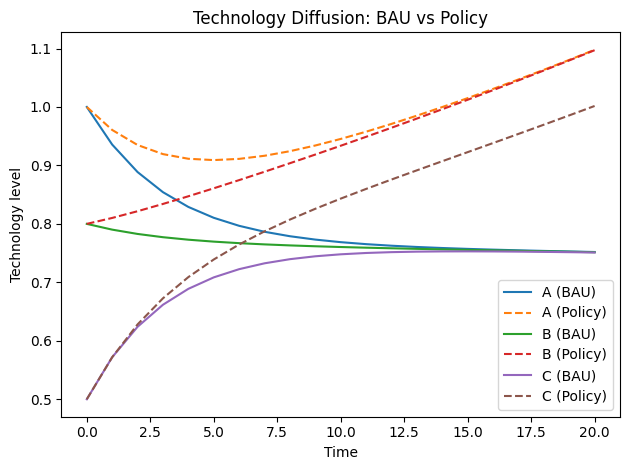

In [4]:
# データ読み込み
df_bau    = pd.read_csv('../results/bau_tech_time_series.csv')
df_policy = pd.read_csv('../results/policy_tech_time_series.csv')

regions = df_bau['region'].unique()
T_max   = df_bau['time'].max()

plt.figure()
for r in regions:
    sub_b = df_bau[df_bau['region']==r]
    sub_p = df_policy[df_policy['region']==r]
    plt.plot(sub_b['time'], sub_b['tech'], label=f'{r} (BAU)')
    plt.plot(sub_p['time'], sub_p['tech'], '--', label=f'{r} (Policy)')

plt.xlabel('Time')
plt.ylabel('Technology level')
plt.title('Technology Diffusion: BAU vs Policy')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/tech_diffusion_curve.png')
plt.show()


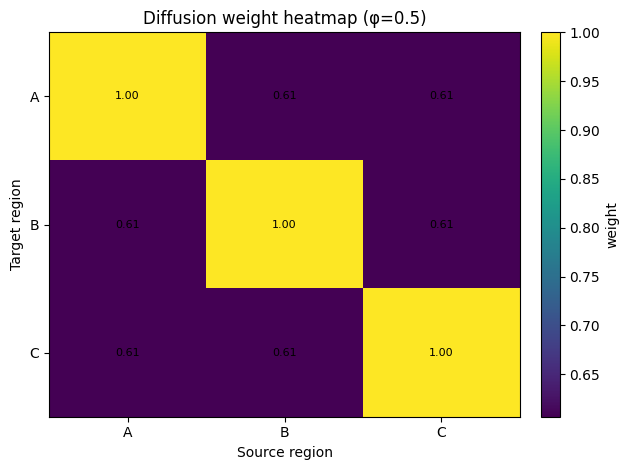

In [5]:
# Cell: Diffusion weight heatmap with annotations

import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_sam, compute_distance_matrix, diffusion_weights

# 1. データ読み込み
regions, _, _, _ = load_sam('../data/processed/sam.csv')

# 2. 距離行列（正規化済み）→ 重み
dist = compute_distance_matrix(regions, base_dist=1.0)
weights = diffusion_weights(dist, phi=0.5)

# 3. プロット
fig, ax = plt.subplots()
im = ax.imshow(weights, aspect='auto')

# 軸ラベル
ax.set_xticks(range(len(regions)))
ax.set_yticks(range(len(regions)))
ax.set_xticklabels(regions)
ax.set_yticklabels(regions)
plt.xlabel('Source region')
plt.ylabel('Target region')
plt.title('Diffusion weight heatmap (φ=0.5)')

# カラーバー
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('weight')

# 4. 各セルに数値を描画
for i in range(len(regions)):
    for j in range(len(regions)):
        ax.text(
            j, i,
            f"{weights.iloc[i, j]:.2f}",
            ha='center', va='center', fontsize=8, color='black'
        )

plt.tight_layout()
plt.savefig('../figures/distance_heatmap_annotated.png')
plt.show()


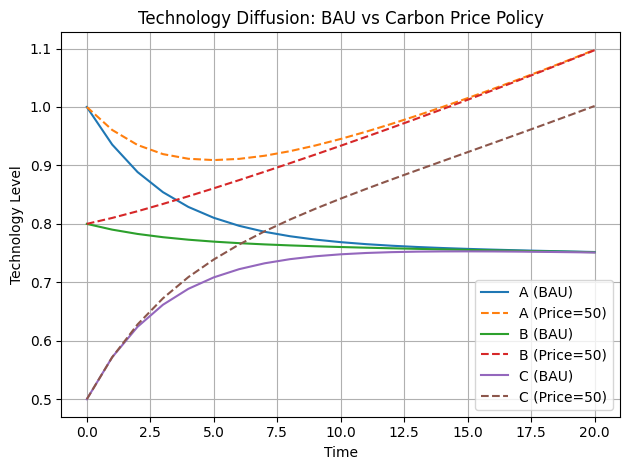

In [6]:
# Cell: BAU vs Carbon Price Comparison

import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import matplotlib.pyplot as plt

# 1) CSV 読み込み
df_bau    = pd.read_csv('../results/bau_tech_time_series.csv')
df_policy = pd.read_csv('../results/policy_tech_time_series.csv')

regions = df_bau['region'].unique()

# 2) プロット設定
plt.figure()
for r in regions:
    sub_b = df_bau[df_bau['region'] == r]
    sub_p = df_policy[df_policy['region'] == r]
    # 実線：BAU、破線：Policy
    plt.plot(sub_b['time'],  sub_b['tech'],
             label=f'{r} (BAU)')
    plt.plot(sub_p['time'],  sub_p['tech'],
             linestyle='--',
             label=f'{r} (Price=50)')

plt.xlabel('Time')
plt.ylabel('Technology Level')
plt.title('Technology Diffusion: BAU vs Carbon Price Policy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# 3) 保存
plt.savefig('../figures/tech_diffusion_bau_vs_policy.png')
plt.show()


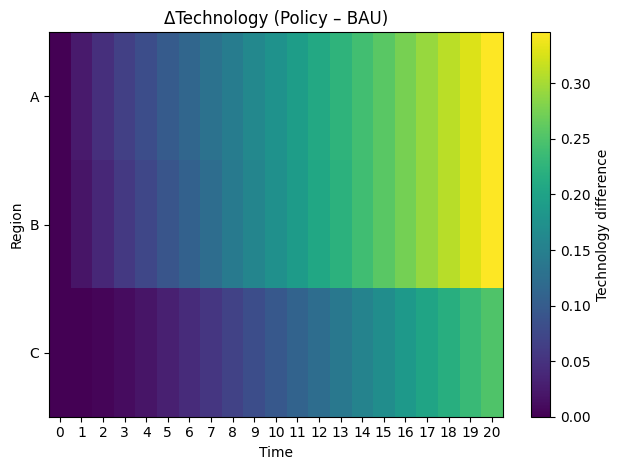

In [7]:
# Cell: ΔTechnology (Policy – BAU) Heatmap

import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import matplotlib.pyplot as plt

# 1. CSV 読み込み
df_bau    = pd.read_csv('../results/bau_tech_time_series.csv')
df_policy = pd.read_csv('../results/policy_tech_time_series.csv')

# 2. BAU vs Policy 差分の計算
#    region, time ごとにマージして差分列を作成
df = pd.merge(
    df_policy, df_bau,
    on=['region','time'],
    suffixes=('_policy','_bau')
)
df['tech_diff'] = df['tech_policy'] - df['tech_bau']

# 3. pivot して行列形式に変換（index, columns, values はキーワード指定）
delta_pivot = df.pivot(
    index='time',
    columns='region',
    values='tech_diff'
)

# 4. ヒートマップ描画
plt.figure()
plt.imshow(delta_pivot.T, aspect='auto')
plt.xticks(range(len(delta_pivot.index)), delta_pivot.index)
plt.yticks(range(len(delta_pivot.columns)), delta_pivot.columns)
plt.xlabel('Time')
plt.ylabel('Region')
plt.title('ΔTechnology (Policy – BAU)')
plt.colorbar(label='Technology difference')
plt.tight_layout()
plt.savefig('../figures/tech_diffusion_delta.png')
plt.show()


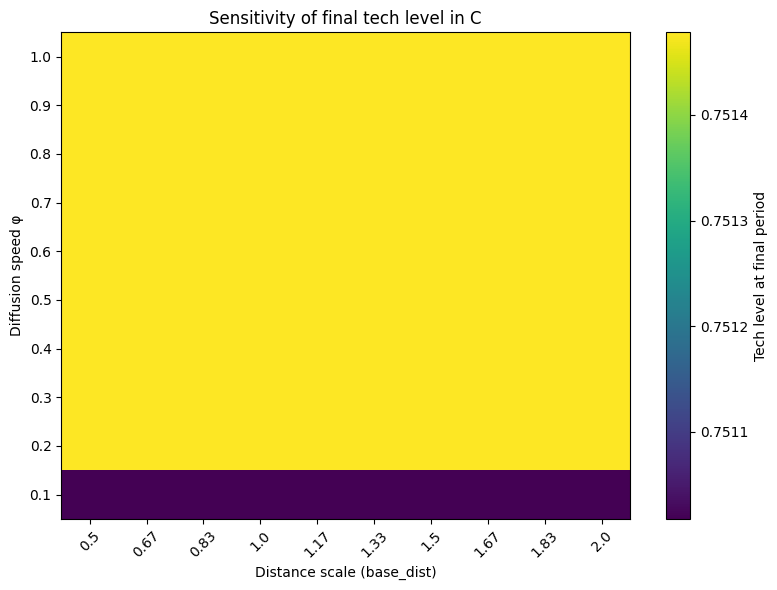

In [8]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.utils import load_sam, compute_distance_matrix, diffusion_weights
from src.model import build_model, solve_model

# Sensitivity analysis settings
regions, K0, L0, T0 = load_sam('../data/processed/sam.csv')
params = json.load(open('../results/params.json'))

target_region = 'C'  # 分析対象の地域
T_end = params['time_horizon']

# グリッド：φ と距離スケール
phi_vals = np.linspace(0.1, 1.0, 10)           # 拡散速度 φ
dist_scales = np.linspace(0.5, 2.0, 10)        # 距離行列の base_dist スケール

# 結果格納用 DataFrame
sensitivity = pd.DataFrame(index=np.round(phi_vals, 2), 
                           columns=np.round(dist_scales, 2))

# グリッド探索
for phi in phi_vals:
    for ds in dist_scales:
        # 距離行列（ds スケール）と重み計算
        dist = compute_distance_matrix(regions, base_dist=ds)
        W = diffusion_weights(dist, phi=phi).values.tolist()
        
        # パラメータ更新
        params['phi'] = float(phi)
        params['W'] = W
        params['carbon_price'] = {r: 0.0 for r in regions}  # BAU
        
        # モデル構築・解法
        model = build_model(params)
        model = solve_model(model, solver_name='ipopt')
        
        # 結果抽出
        val = model.Tech[target_region, T_end].value
        sensitivity.loc[round(phi,2), round(ds,2)] = val

# 数値を float に変換
sensitivity = sensitivity.astype(float)

# ヒートマップ描画
plt.figure(figsize=(8, 6))
im = plt.imshow(sensitivity.values, origin='lower', aspect='auto')

# 軸ラベル設定
plt.xticks(ticks=range(len(dist_scales)), labels=np.round(dist_scales, 2), rotation=45)
plt.yticks(ticks=range(len(phi_vals)), labels=np.round(phi_vals, 2))

plt.xlabel('Distance scale (base_dist)')
plt.ylabel('Diffusion speed φ')
plt.title(f'Sensitivity of final tech level in {target_region}')

# カラーバー
cbar = plt.colorbar(im)
cbar.set_label('Tech level at final period')

plt.tight_layout()
plt.savefig('../figures/sensitivity_heatmap.png')
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_7948\1468281674.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


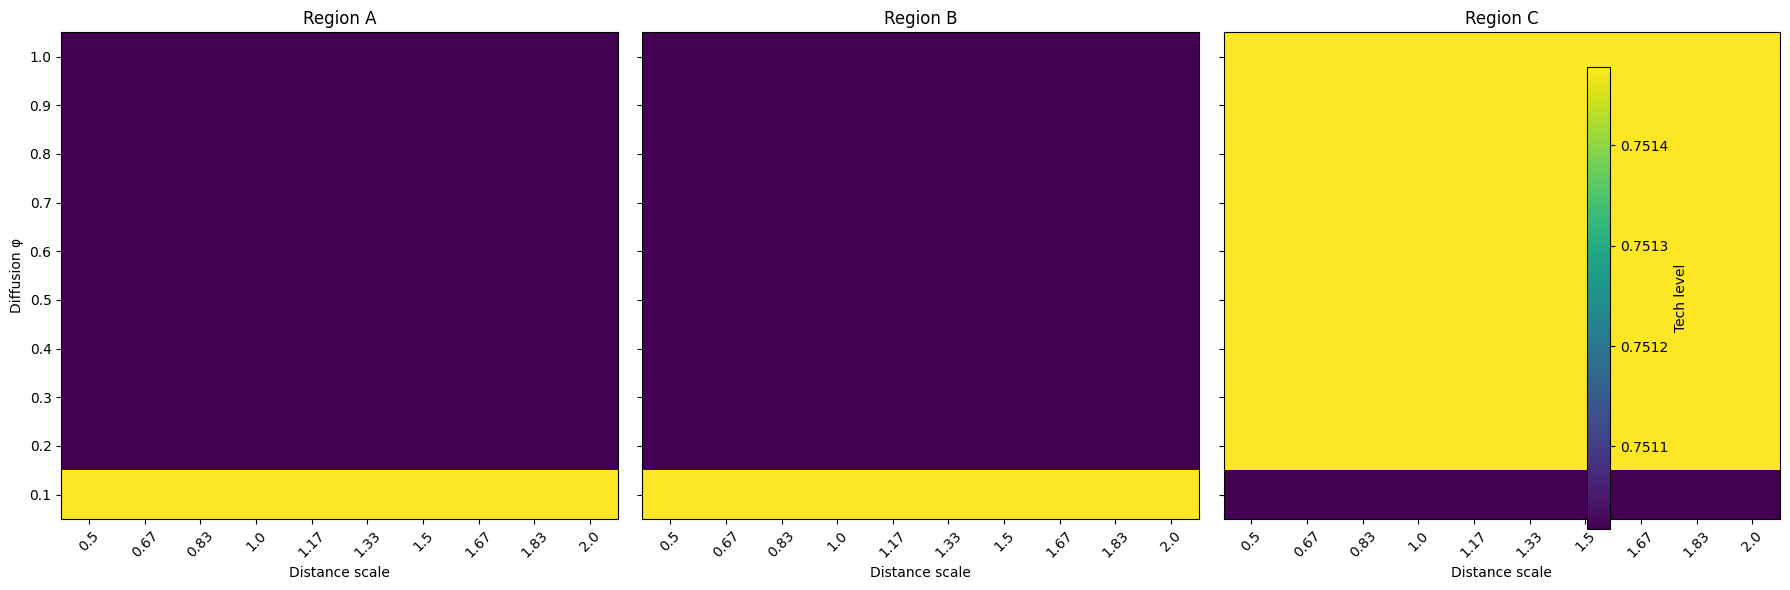

In [9]:
import os, sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ―― プロジェクト構成に合わせてパスをセット ――
proj_root = os.getcwd()  # カレントをプロジェクトルートに
sys.path.insert(0, proj_root)

# src/utils.py, src/model.py をインポート
from src.utils         import load_sam, compute_distance_matrix, diffusion_weights
from src.model         import build_model, solve_model

# --- データ読み込み ---
regions, K0, L0, T0 = load_sam(os.path.join(proj_root, '../data/processed/sam.csv'))
with open(os.path.join(proj_root, '../results/params.json')) as f:
    params = json.load(f)
T_end = params['time_horizon']

# --- 感度分析グリッド設定 ---
phi_vals     = np.linspace(0.1, 1.0, 10)   # 拡散速度 φ
dist_scales  = np.linspace(0.5, 2.0, 10)   # 距離スケール

# --- 各地域ごとに sensitivity DataFrame を構築 ---
sensitivity = {}
for target in regions:
    mat = pd.DataFrame(
        index=np.round(phi_vals,2),
        columns=np.round(dist_scales,2),
        dtype=float
    )
    for phi in phi_vals:
        for ds in dist_scales:
            # パラメータ更新
            params['phi'] = float(phi)
            D = compute_distance_matrix(regions, base_dist=ds)
            params['W'] = diffusion_weights(D, phi=phi).values.tolist()
            # BAU: carbon_price=0
            cp = {r: 0.0 for r in regions}
            params['carbon_price'] = cp

            # モデル構築・解法
            m = build_model(params)
            for r,p in cp.items():
                m.carbon_price[r] = p
            m = solve_model(m, solver_name='ipopt')

            # 最終時点の技術水準
            mat.at[round(phi,2), round(ds,2)] = m.Tech[target, T_end].value

    sensitivity[target] = mat

# --- ヒートマップを横並びでプロット ---
fig, axes = plt.subplots(1, len(regions), figsize=(18,6), sharey=True)
for ax, region in zip(axes, regions):
    im = ax.imshow(sensitivity[region].values, origin='lower', aspect='auto')
    φ_labels  = np.round(phi_vals,2)
    ds_labels = np.round(dist_scales,2)
    ax.set_xticks(range(len(ds_labels)))
    ax.set_xticklabels(ds_labels, rotation=45)
    ax.set_yticks(range(len(φ_labels)))
    ax.set_yticklabels(φ_labels)
    ax.set_xlabel('Distance scale')
    ax.set_title(f'Region {region}')

axes[0].set_ylabel('Diffusion φ')
fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.04, label='Tech level')

plt.tight_layout()
plt.savefig(os.path.join(proj_root, '../figures/sensitivity_three_regions.png'))
plt.show()


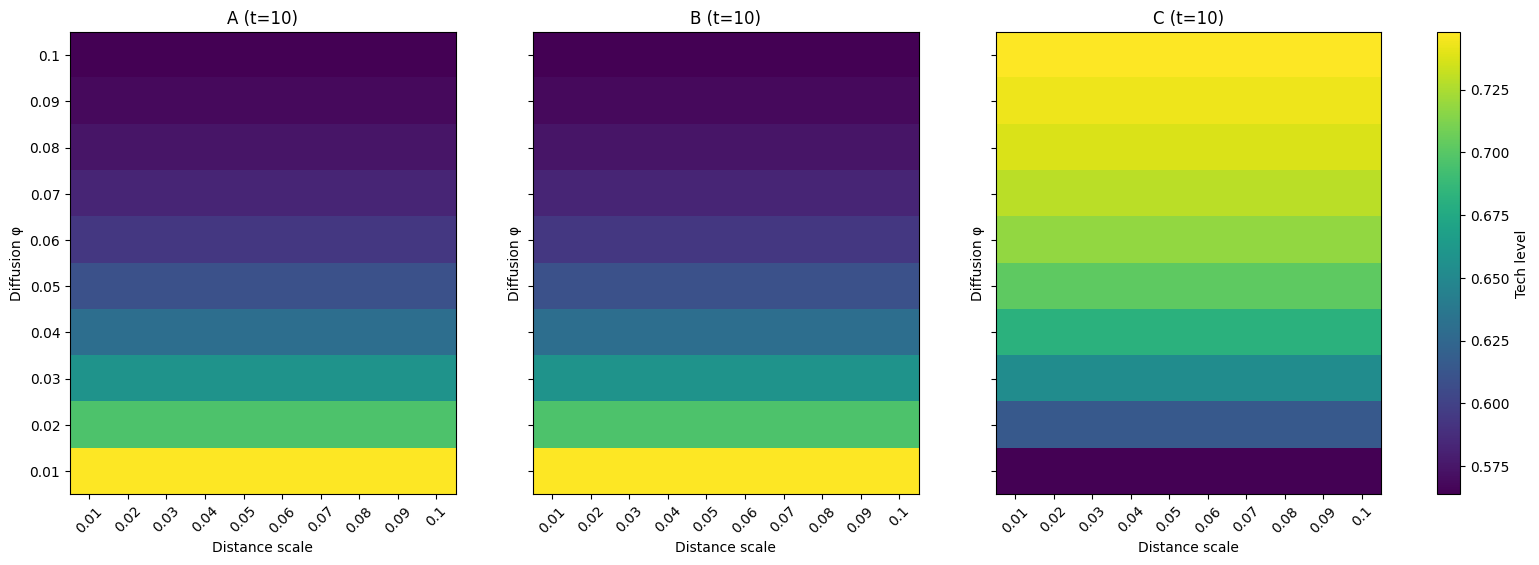

In [13]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# プロジェクトルートを指定
proj_root = '..'  # 実際のパスに合わせてください
sys.path.insert(0, proj_root)
from src.utils import load_sam, compute_distance_matrix, diffusion_weights
from src.model import build_model, solve_model

# データ読込
regions, _, _, _ = load_sam(os.path.join(proj_root,'data/processed/sam.csv'))
with open(os.path.join(proj_root,'results/params.json')) as f:
    params = json.load(f)

# 中間期を指定
full_T    = params['time_horizon']
analysis_T = full_T // 2

# 感度分析の範囲
phi_vals    = np.linspace(0.01, 0.1, 10)
dist_scales = np.linspace(0.01, 0.1, 10)

# 結果格納
sensitivity = {}
for target in regions:
    mat = pd.DataFrame(
        index=np.round(phi_vals,2),
        columns=np.round(dist_scales,2),
        dtype=float
    )
    for phi in phi_vals:
        for ds in dist_scales:
            # 距離→重み更新
            params['phi'] = float(phi)
            D = compute_distance_matrix(regions, base_dist=ds)
            params['W'] = diffusion_weights(D, phi=phi).values.tolist()
            # BAU
            params['carbon_price'] = {r:0.0 for r in regions}

            # モデル構築・解法
            m = build_model(params)
            for r in regions:
                m.carbon_price[r] = 0.0
            m = solve_model(m, solver_name='ipopt')

            # 中間期の技術水準を取得
            mat.at[round(phi,2), round(ds,2)] = m.Tech[target, analysis_T].value

    sensitivity[target] = mat

# プロット
fig, axes = plt.subplots(1, len(regions), figsize=(18,6), sharey=True)
for ax, region in zip(axes, regions):
    im = ax.imshow(sensitivity[region].values, origin='lower', aspect='auto')
    ax.set_title(f'{region} (t={analysis_T})')
    ax.set_xlabel('Distance scale')
    ax.set_ylabel('Diffusion φ')
    ax.set_xticks(range(len(dist_scales)))
    ax.set_xticklabels(np.round(dist_scales,2), rotation=45)
    ax.set_yticks(range(len(phi_vals)))
    ax.set_yticklabels(np.round(phi_vals,2))

fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.02, pad=0.04, label='Tech level')
# plt.tight_layout()
plt.savefig(os.path.join(proj_root,'figures/sensitivity_midterm.png'))
plt.show()


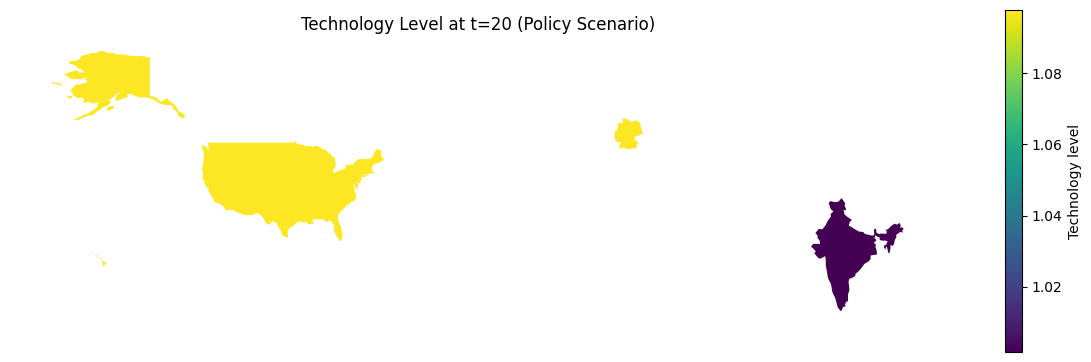

In [19]:
import os
import sys
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ── プロジェクトルートを設定 ──
proj_root = ".."
sys.path.insert(0, proj_root)

# ── 結果データ読み込み ──
df = pd.read_csv(os.path.join(proj_root, 'results', 'policy_tech_time_series.csv'))
with open(os.path.join(proj_root, 'results', 'params.json')) as f:
    params = json.load(f)
T_end = params['time_horizon']

# 最終期のデータを抽出
df_end = df[df['time'] == T_end].copy()

# ── シェープファイルのパス ──
shapefile_dir = os.path.join(proj_root, 'data', 'shapefiles')
shapefile = os.path.join(shapefile_dir, 'ne_110m_admin_0_countries.shp')
if not os.path.exists(shapefile):
    raise FileNotFoundError(
        f"シェープファイルが見つかりません: {shapefile}\n"
        "Natural Earth の「Admin 0 – Countries」を上記ディレクトリに置いてください。"
    )

# ── 世界地図データ読み込み ──
world = gpd.read_file(shapefile)

# ── 地域コード → シェープファイル上の国名カラムにマッピング ──
# （環境に合わせて対応付けを調整してください）
region_to_country = {
    'A': 'United States of America',
    'B': 'Germany',
    'C': 'India',
}
df_end['country'] = df_end['region'].map(region_to_country)

# ── GeoDataFrame の作成 ──
gdf = world.merge(
    df_end,
    left_on='NAME',       # シェープファイルによっては 'NAME' または 'ADMIN'
    right_on='country',
    how='inner'
)

# ── プロット ──
fig, ax = plt.subplots(figsize=(12, 6))
gdf.plot(
    column='tech',
    cmap='viridis',      # 好みのカラーマップ
    legend=True,
    ax=ax,
    legend_kwds={'label': "Technology level", 'shrink': 0.6}
)
ax.set_title(f'Technology Level at t={T_end} (Policy Scenario)')
ax.set_axis_off()

plt.tight_layout()
out_path = os.path.join(proj_root, 'figures', 'choropleth_policy.png')
plt.savefig(out_path, dpi=300)
plt.show()


## 南アジア5国バージョン

In [29]:
#!/usr/bin/env python3
# run_south_asia_analysis.py

import os, sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# ── プロジェクト構成に合わせてパスを設定 ──
proj_root = ".."
sys.path.insert(0, proj_root)

from src.utils import load_sam, compute_distance_matrix, diffusion_weights
from src.model import build_model, solve_model

In [30]:
# 1. Calibration
sam_path    = os.path.join(proj_root, 'data', 'processed', 'sam.csv')
params_path = os.path.join(proj_root, 'results', 'params.json')
regions, K0, L0, T0 = load_sam(sam_path)

# カリブレーションパラメータ
calib = {
    'regions': regions,
    'K0': K0, 'L0': L0, 'T0': T0,
    'alpha': 0.36,
    'phi':   0.1,
    'gamma': 0.0005,
    'delta': 0.001,
    'time_horizon': 20,
    # 先進国として技術自律成長を適用する地域リスト
    # 南アジアの場合、たとえばインドだけ policy 適用したいなら ['IN'] など
    'advanced_regions': regions[:]  
}
with open(params_path, 'w') as f:
    json.dump(calib, f, indent=2)
print(f"Calibration saved → {params_path}")

# 2. Run Scenarios (BAU, Policy)
from src.scenarios import run_scenario

bau_csv    = os.path.join(proj_root, 'results', 'bau_tech_time_series.csv')
policy_csv = os.path.join(proj_root, 'results', 'policy_tech_time_series.csv')

Calibration saved → ..\results\params.json


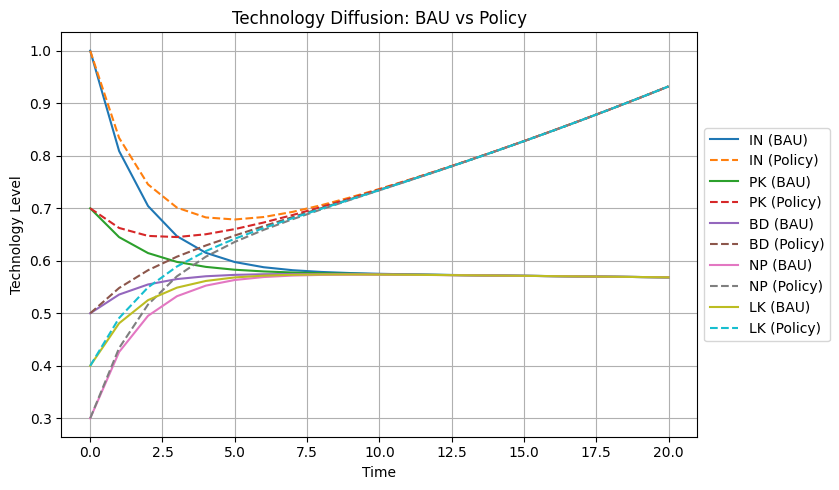

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# プロジェクトルートに合わせて設定
proj_root = '..'
bau_csv    = os.path.join(proj_root, 'results', 'bau_tech_time_series.csv')
policy_csv = os.path.join(proj_root, 'results', 'policy_tech_time_series.csv')

# データ読み込み
df_bau = pd.read_csv(bau_csv)
df_pol = pd.read_csv(policy_csv)
regions = df_bau['region'].unique()

# プロット
fig, ax = plt.subplots(figsize=(10, 5))
for r in regions:
    b = df_bau[df_bau.region == r]
    p = df_pol[df_pol.region == r]
    ax.plot(b.time, b.tech,  label=f'{r} (BAU)')
    ax.plot(p.time, p.tech, '--', label=f'{r} (Policy)')

# 軸ラベル・タイトル
ax.set_xlabel('Time')
ax.set_ylabel('Technology Level')
# ax.set_title('Technology Diffusion: BAU vs Policy')
ax.grid(True)

# 凡例をプロット領域右外に配置
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# レイアウト調整：右側に余白を確保
plt.tight_layout(rect=[0, 0, 0.85, 1])

# 保存
out_path = os.path.join(proj_root, 'figures', 'tech_diffusion_bau_vs_policy.png')
plt.savefig(out_path, dpi=150)
plt.show()


In [32]:
# 4. ΔTechnology Heatmap
df = pd.merge(df_pol, df_bau, on=['region','time'], suffixes=('_pol','_bau'))
df['diff'] = df.tech_pol - df.tech_bau
pivot = df.pivot(index='time', columns='region', values='diff')
plt.figure()
plt.imshow(pivot.T, origin='lower', aspect='auto')
plt.xticks(range(len(pivot.index)), pivot.index)
plt.yticks(range(len(pivot.columns)), pivot.columns)
plt.xlabel('Time'); plt.ylabel('Region')
plt.title('ΔTechnology (Policy – BAU)')
plt.colorbar(label='Tech difference'); plt.tight_layout()
out = os.path.join(proj_root,'figures','tech_diffusion_delta.png')
plt.savefig(out, dpi=150); print(f"Saved → {out}")
plt.close()

Saved → ..\figures\tech_diffusion_delta.png


In [38]:
# 5. Sensitivity: φ vs base_dist at mid-term
mid_t = calib['time_horizon']//2
phi_vals    = np.linspace(0.01,0.1,10)
dist_scales = np.linspace(0.01,0.1,10)
sens = {r: pd.DataFrame(index=np.round(phi_vals,2),
                        columns=np.round(dist_scales,2), dtype=float)
        for r in regions}

for phi in phi_vals:
    for ds in dist_scales:
        # update params
        calib['phi'] = float(phi)
        D = compute_distance_matrix(regions, base_dist=ds)
        calib['W'] = diffusion_weights(D, phi=phi).values.tolist()
        calib['carbon_price'] = {r:0.0 for r in regions}
        m = build_model(calib)
        for rr in regions:
            m.carbon_price[rr] = 0.0
        m = solve_model(m, solver_name='ipopt')
        for r in regions:
            sens[r].at[round(phi,2), round(ds,2)] = m.Tech[r, mid_t].value

# plot sensitivity for all regions in grid
n = len(regions)
cols = min(3,n); rows = int(np.ceil(n/cols))
fig, axs = plt.subplots(rows, cols, figsize=(4*cols,3*rows), sharey=True)
axs = axs.flatten()
for ax, r in zip(axs, regions):
    im = ax.imshow(sens[r].values, origin='lower', aspect='auto')
    ax.set_title(f'{r} (t={mid_t})')
    ax.set_xticks(range(len(dist_scales)))
    ax.set_xticklabels(np.round(dist_scales,2),rotation=45)
    ax.set_yticks(range(len(phi_vals)))
    ax.set_yticklabels(np.round(phi_vals,2))
    ax.set_xlabel('Dist scale')
axes[0].set_ylabel('Diffusion φ')
fig.colorbar(im, ax=axs.tolist(), fraction=0.02, pad=0.04, label='Tech level')
# plt.tight_layout()
out = os.path.join(proj_root,'figures','sensitivity_south_asia.png')
plt.savefig(out, dpi=150); print(f"Saved → {out}")
plt.close()

Saved → ..\figures\sensitivity_south_asia.png


In [36]:
# 6. Choropleth Map (Policy, final period)
csv = policy_csv
with open(params_path) as f:
    p = json.load(f)
T_end = p['time_horizon']
df_end = pd.read_csv(csv)
df_end = df_end[df_end.time==T_end]
# 地域→国名マッピング（sam.csv に合わせて調整）
region_to_country = {
    regions[i]: name for i,name in enumerate([
        'India','Pakistan','Bangladesh','Nepal','Sri Lanka'
    ])
}
df_end['country'] = df_end['region'].map(region_to_country)
# シェープファイル読み込み（事前に data/shapefiles 配下に）
shp = os.path.join(proj_root,'data','shapefiles','ne_110m_admin_0_countries.shp')
world = gpd.read_file(shp)
gdf = world.merge(df_end, left_on='NAME', right_on='country', how='inner')
fig, ax = plt.subplots(1,1,figsize=(10,6))
gdf.plot(column='tech', legend=True, ax=ax,
         legend_kwds={'label':'Tech level','shrink':0.6})
ax.set_title(f'Technology Level at t={T_end} (Policy)')
ax.set_axis_off()
out = os.path.join(proj_root,'figures','choropleth_policy.png')
plt.savefig(out, dpi=150); print(f"Saved → {out}")
plt.close()

print("=== All done for South Asia 5 countries ===")

Saved → ..\figures\choropleth_policy.png
=== All done for South Asia 5 countries ===
